<a href="https://colab.research.google.com/github/Kira1108/AirportScreenGeneration/blob/main/Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
SHAPE = (224,224,3)

TRAIN_PATH = '/content/drive/MyDrive/WindowDetector/train'
TEST_PATH = '/content/drive/MyDrive/WindowDetector/test'

In [12]:
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

import os
import random
import itertools
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
tf.__version__

'2.8.2'

In [20]:
SHAPE = (224,224,3)

TRAIN_PATH = '/content/drive/MyDrive/WindowDetector/train'
TEST_PATH = '/content/drive/MyDrive/WindowDetector/test'

In [21]:
W, H = 224,224

# file types to handle
filetypes = ['jpeg','jpg','png']

negative_name = "normal"
positive_name = "windows"

negatives = [f 
         for t in filetypes 
         for f in (Path(TEST_PATH) / negative_name).glob(f"*.{t}")]


positives = [f 
         for t in filetypes 
         for f in (Path(TEST_PATH) / positive_name).glob(f"*.{t}")]


def load_images(paths):
    images = []
    for i,p in enumerate(paths):
        try:
            img = np.asarray(Image.open(p).convert("RGB"))
            img = cv2.resize(img,(W,H))
            images.append(img)
        except:
            print(p)
    return np.array(images)

positive_images = load_images(positives)
negative_images = load_images(negatives)

In [22]:
class WindowModel(tf.keras.models.Model):
    def __init__(self):
        super().__init__()

        self.vgg = VGG16(weights = 'imagenet', include_top = True, input_shape = SHAPE)
        self.vgg = Model(self.vgg.input, self.vgg.layers[-3].output)
        self.vgg.trainable = False
        self.act = tf.keras.layers.Activation('relu')
        self.dense1 = Dense(512, activation='relu')
        self.dense2 = Dense(128, activation='relu')
        self.out_dense = Dense(2, activation='softmax')

    def call(self, inp, training = True):
        x = preprocess_input(inp)
        x = GaussianNoise(0.1)(x)
        x = self.vgg(x)

        if training:

            noise = tf.zeros_like(x)
            noise = GaussianNoise(0.1)(noise)

            concat = tf.concat([x, noise], axis=0)
            x = self.act(concat)

        x = self.dense1(x)
        x = self.dense2(x)
        return self.out_dense(x)



In [24]:
def load_model(weights = "window_weights.h5"):
    newmodel = WindowModel()
    newmodel(np.random.random((1,224,224,3)))
    newmodel.load_weights(weights)
    return newmodel

loaded = load_model("/content/drive/MyDrive/WindowDetector/saved_model/window_weights.h5")

In [25]:
predict_positive = np.argmax(loaded(positive_images, training = False), axis = -1)
predict_negative = np.argmax(loaded(negative_images, training = False), axis = -1)

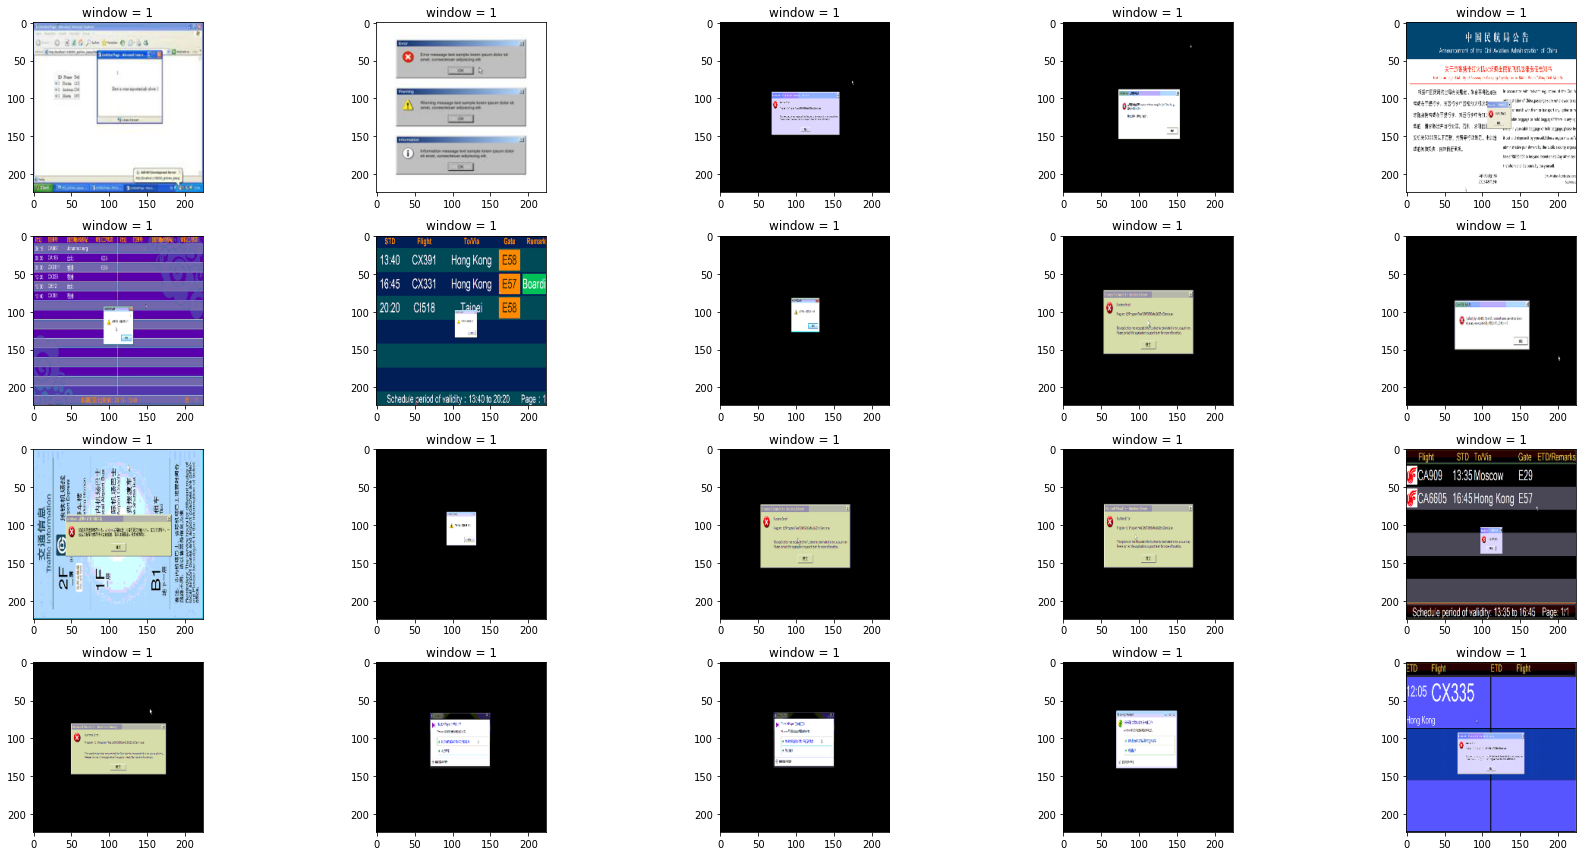

In [26]:
plt.subplots(figsize = (25,12))
for i in range(20):
    plt.subplot(4,5, i+1)
    plt.imshow(positive_images[i])
    plt.title("window = {}".format(predict_positive[i]))
plt.tight_layout()

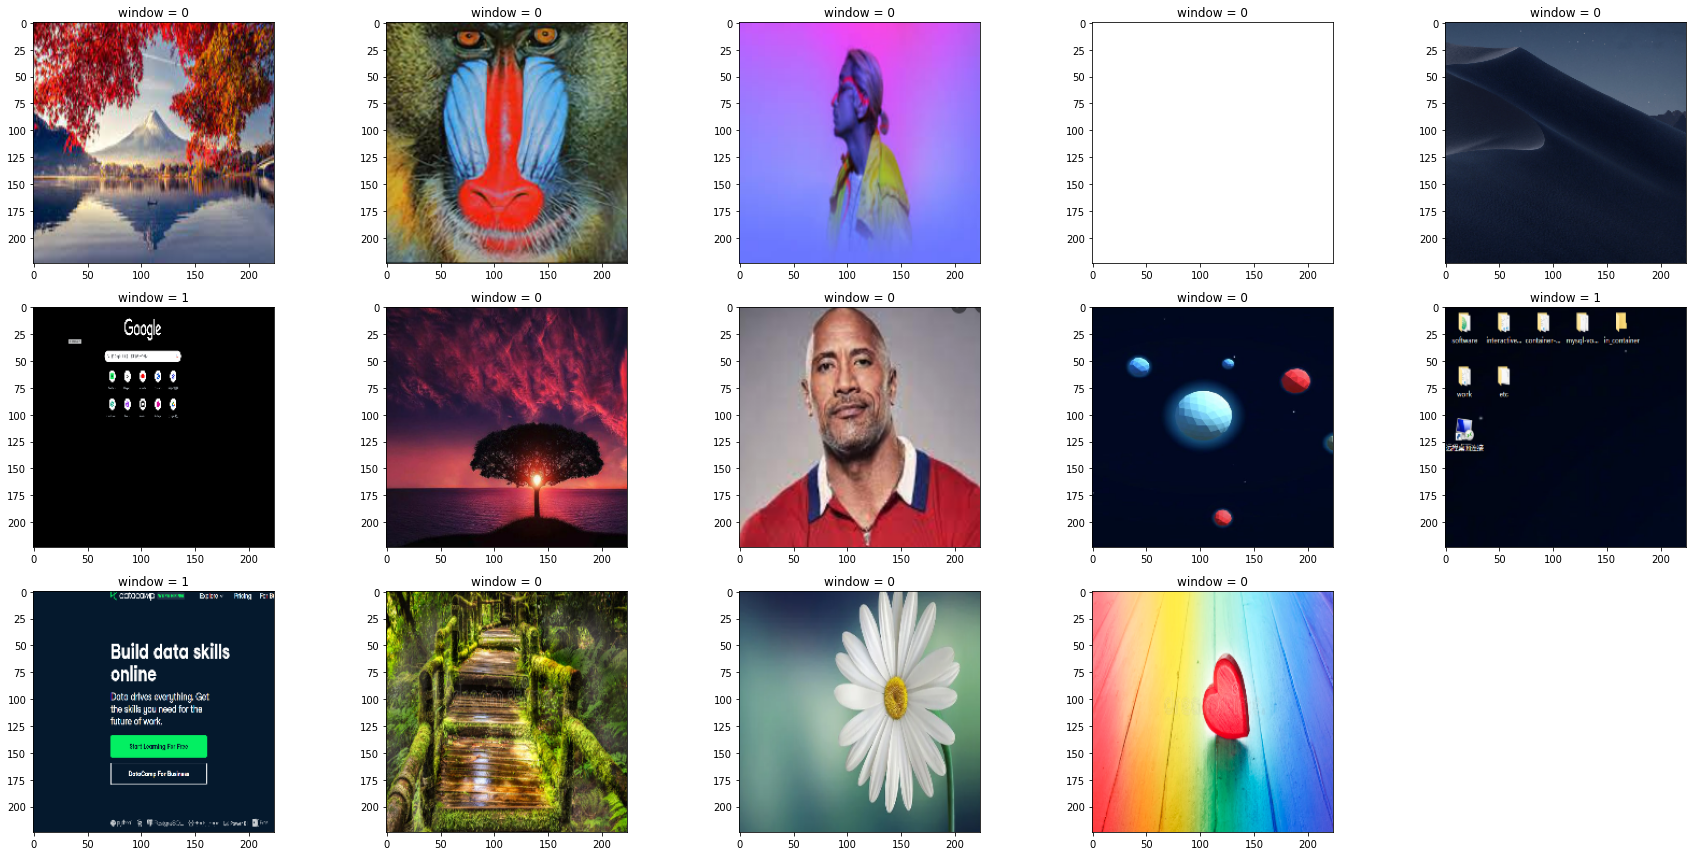

In [27]:
plt.subplots(figsize = (25,12))
for i in range(14):
    plt.subplot(3,5, i+1)
    plt.imshow(negative_images[i])
    plt.title("window = {}".format(predict_negative[i]))
plt.tight_layout()